In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # TensorFlow has detected GPUs
    print("GPU(s) available:")
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    # No GPUs detected
    print("No GPU detected. TensorFlow will use the CPU.")


GPU(s) available:
- /physical_device:GPU:0


In [ ]:
from keras.src import utils
import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.applications import ResNet101
# Define your dataset directories
train_data_dir = "/content/drive/MyDrive/Models/train"
validation_data_dir = "/content/drive/MyDrive/Models/val"
batch_size = 32
target_size = (224, 224)

# Load pre-trained ResNet101 model with top (fully connected) layers
base_model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

num_classes = 20  # Number of classes

# Create a custom top for the model
x = base_model.layers[-2].output  # Use the second-to-last layer as the base
x = layers.Dense(num_classes, activation='softmax')(x)

# Create the final fine-tuned model
model = models.Model(inputs=base_model.input, outputs=x)

# Compile the model with all requested metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc')])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

# Fine-tune the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=200,  # Use a large number, early stopping will handle it
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    # callbacks=[early_stopping]
)

# Save the fine-tuned model
model.save('fine_tuned_resnet101.h5')

# Evaluate the model on the validation set
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)

# Convert predictions to class indices
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Calculate additional metrics
classification_report_str = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys(), zero_division=1)

# Print the classification report
print(classification_report_str)

179648224/179648224 [==============================] - 2s 0us/step
Found 1477 images belonging to 20 classes.
Found 1449 images belonging to 20 classes.
Epoch 1/200
46/46 [==============================] - 1095s 24s/step - loss: 2.9340 - accuracy: 0.1246 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6141 - val_loss: 2.9362 - val_accuracy: 0.0889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6155
Epoch 2/200
46/46 [==============================] - 39s 861ms/step - loss: 2.8602 - accuracy: 0.1481 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6516 - val_loss: 2.9436 - val_accuracy: 0.0875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6204
Epoch 3/200
46/46 [==============================] - 41s 887ms/step - loss: 2.8204 - accuracy: 0.1453 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6697 - val_loss: 2.8983 - val_accuracy: 0.0958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6373
Epoch 4/200
46/46 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 14s 267ms/step
              precision    recall  f1-score   support

   aeroplane       0.03      0.02      0.03        90
     bicycle       0.03      0.01      0.02        73
        bird       0.07      0.15      0.09        98
        boat       0.03      0.03      0.03        68
      bottle       0.00      0.00      0.00        67
         bus       0.04      0.09      0.06        69
         car       0.10      0.03      0.05        66
         cat       0.09      0.05      0.07       114
       chair       1.00      0.00      0.00        53
         cow       0.40      0.03      0.05        71
 diningtable       1.00      0.00      0.00        28
         dog       0.05      0.02      0.02       119
       horse       0.02      0.01      0.02        75
   motorbike       0.05      0.13      0.07        70
      person       0.10      0.27      0.14       127
 pottedplant       0.00      0.00      0.00        33
       sheep       0.00  

46/46 [==============================] - 25s 551ms/step


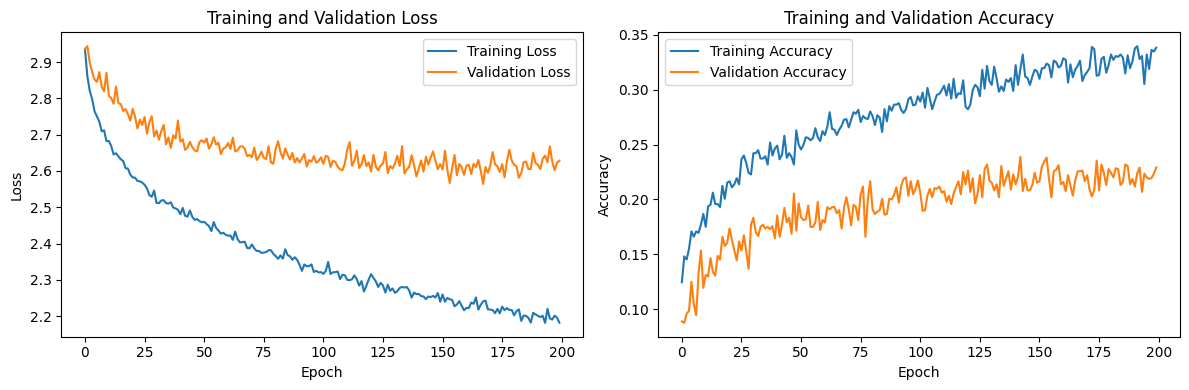

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.0392
Precision: 0.0482
Recall: 0.0524


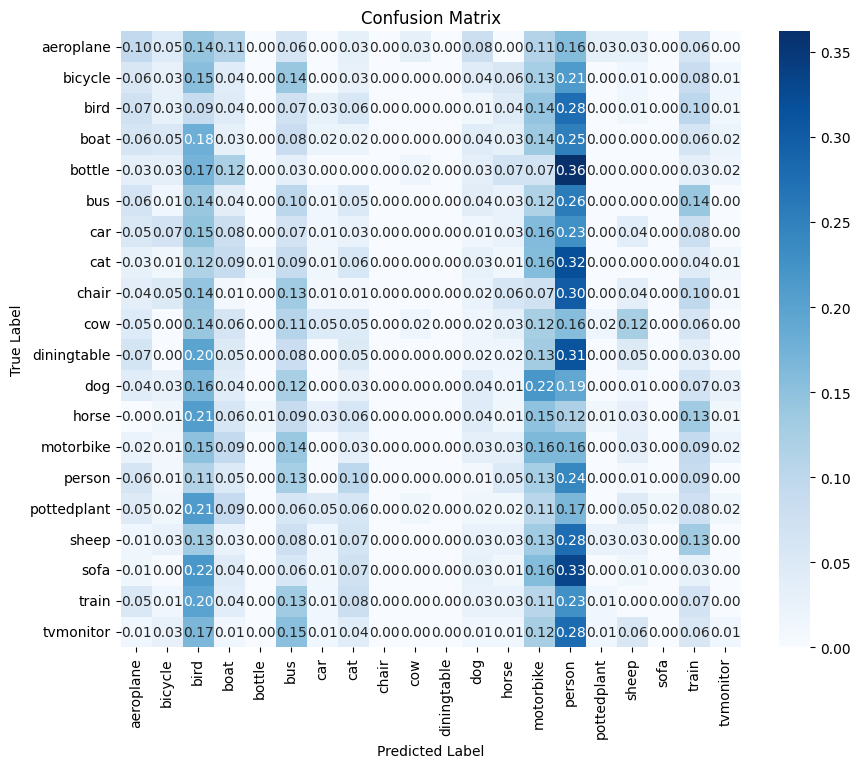

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import load_model

def plot_metrics(history):
    # Plot training loss vs validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return f1, precision, recall

def plot_heatmap(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Uncomment the next line if you want to load the model from the saved file
# model = load_model('fine_tuned_resnet50.h5')

# Example: Assuming you have a list of true labels and predicted labels
# You need to replace this with your actual labels
y_true_example = np.random.randint(0, num_classes, size=(validation_generator.samples,))
y_pred_example = model.predict(validation_generator)
y_pred_classes_example = np.argmax(y_pred_example, axis=1)

# Plot training metrics
plot_metrics(history)

# Calculate and print additional metrics
f1, precision, recall = calculate_metrics(y_true_example, y_pred_classes_example)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot confusion matrix
class_names = list(validation_generator.class_indices.keys())
plot_heatmap(y_true_example, y_pred_classes_example, class_names)


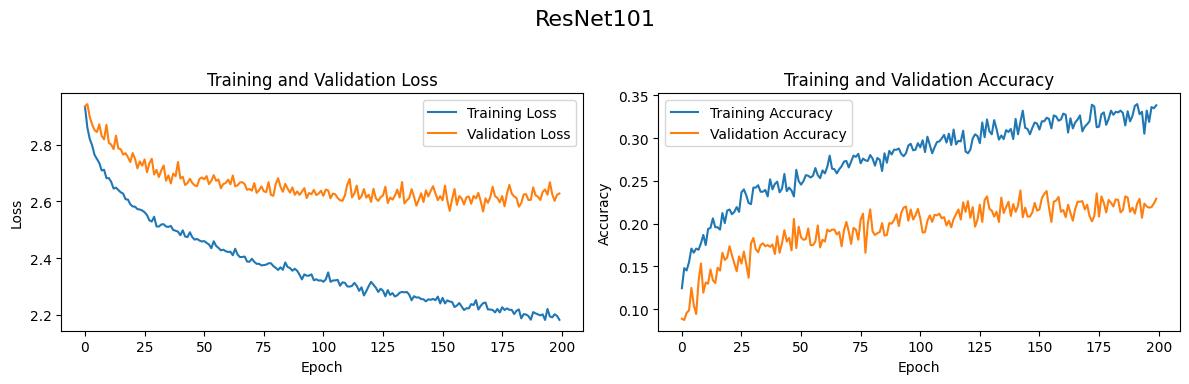

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import load_model

def plot_metrics(history):
    # Plot training loss vs validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle('ResNet101', fontsize=16)  # Overall title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

plot_metrics(history)
# Rest of the script remains unchanged
